# <b> Sarcasm Detector

### <b> Setup

In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import *
import json
import seaborn as sea
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import sent_tokenize, word_tokenize
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split

import string
import nltk 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(stop_words='english')

from keras.backend.tensorflow_backend import set_session
#set tensorflow to grow memory usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # d
config.log_device_placement = True 
sess = tf.Session(config = config)
set_session(sess)

### <b> Data Access 

In [2]:
with open("../data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [3]:
sentences[0:2]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]

In [4]:
labels[0:10]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

### <b> Clean Text

In [5]:
'''
Function for remove symbols ans stopwords 
'''
def _cleasing_(text):
    words = word_tokenize(text) 
    text = [w.lower() for w in words if w not in string.punctuation and w.isalpha()]
    text = [w for w in text if w not in stop_words]
    return ' '.join(text)

In [6]:
sentences = [_cleasing_(line) for line in sentences]

### <b> Exploratory Data Analysis

#### <b> Words Frequency

In [7]:
'''
Compute the frequency distibution of words from corpus 
'''
def words_frequency(tokens):
    # frequency of tokens
    text = nltk.FreqDist(tokens)
    
    # organize data in dataframe
    words_df = pd.DataFrame()
    words_df['words'] = text.keys()
    words_df['freq'] = text.values()
    
    # Normalize
    words_df['norm'] = [x/unique_words_quantity for x in words_df['freq']]
    return words_df.sort_values(by = 'freq', ascending=False)

#join all lines in a concise text
full_text = ''.join(sentences)

# words as individual tokens
tokens = word_tokenize(full_text)

# corpus unique words
unique_words_quantity = len(set(tokens))

# words frequency in a dataframe
df_frequency = words_frequency(tokens)
df_frequency.head()

,words,freq,norm
54,trump,1087,0.023645
321,new,988,0.021491
59,man,734,0.015966
470,says,372,0.008092
495,one,361,0.007853


In [8]:
print(unique_words_quantity)

45972


#### <b> Word Cloud

In [9]:
def word_cloud(tokens):
    from wordcloud import WordCloud
    frequency = nltk.FreqDist(tokens)
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequency)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

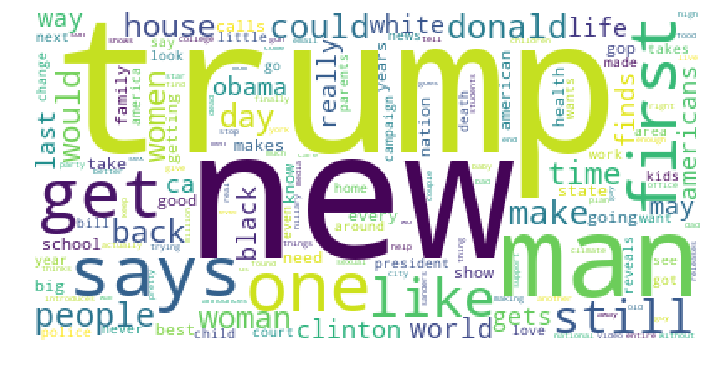

In [10]:
word_cloud(tokens)

### <b>  TDIDF

In [11]:
'''
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
'''
def _tf_idf_(docs):
    # this steps generates word counts for the words in your docs
    word_count_vector=cv.fit_transform(docs)
    
    # weights based on count
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    # organize data in dataframe
    df = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["TFIDF"])
    df =  df.sort_values(by=['TFIDF'], ascending=False)

    return df

tf_idf = _tf_idf_(tokens)

tf_idf.head(10)

,TFIDF
lifetimebush,12.228418
pantsmerkel,12.228418
pantherseagles,12.228418
pantiesreflecting,12.228418
pantsawkward,12.228418
pantsgroundbreaking,12.228418
pantshilary,12.228418
pantskey,12.228418
pantsmadeleine,12.228418
pantspaul,12.228418


Too many misspelled words lead to weighted words

### <b> POS Tag

In [12]:
from nltk import RegexpParser

In [13]:
# process the tagging
pos_words = nltk.pos_tag(tokens)
print(pos_words[0:10])

[('former', 'JJ'), ('versace', 'NN'), ('store', 'NN'), ('clerk', 'NN'), ('sues', 'VBZ'), ('secret', 'JJ'), ('code', 'NN'), ('minority', 'NN'), ('shoppersrevival', 'NN'), ('catches', 'NNS')]


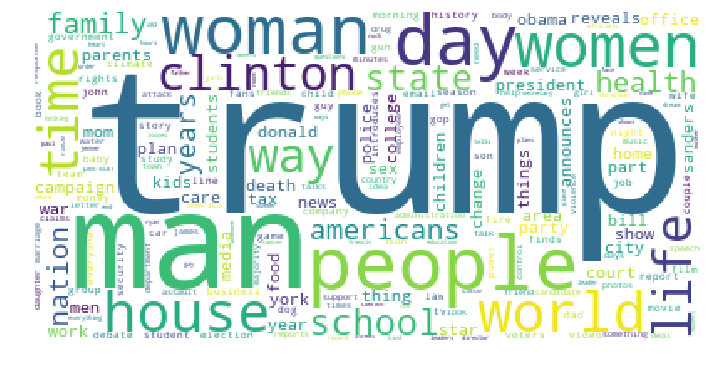

In [14]:
# filter by Nouns
nn_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('NN')]
list_nn  = [nn[0] for nn in nn_tagged]
word_cloud(list_nn)

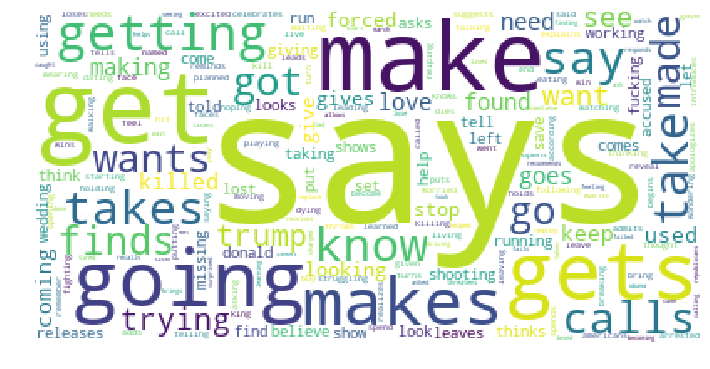

In [15]:
# filter by Verbs
vb_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('VB')]
list_vb  = [vb[0] for vb in vb_tagged]
word_cloud(list_vb)

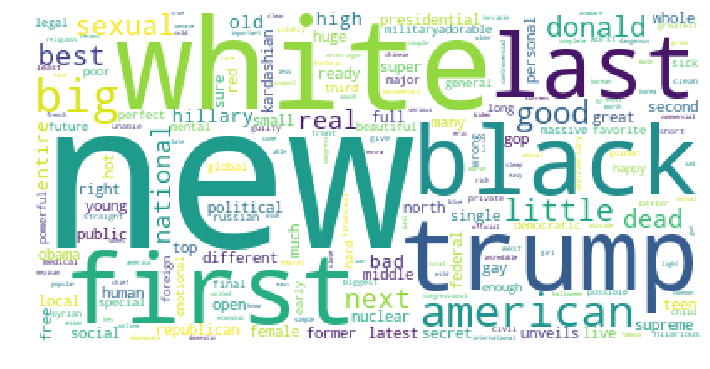

In [16]:
# filter by Adjectives
jj_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('JJ')]
list_jj  = [jj[0] for jj in jj_tagged]
word_cloud(list_jj)

In [17]:
len(nn_tagged), len(vb_tagged), len(jj_tagged)

(74246, 33691, 31081)

### <b> Configuring parameters

In [18]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
padding_type='post'
oov_tok = "<OOV>"

In [19]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentences, labels, test_size = 0.1, random_state = 42)

In [20]:
len(sentence_train), len(label_train), len(sentence_test), len(label_test)

(24038, 24038, 2671, 2671)

### <b> Encoding

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# build vocabulary
tokenizer.fit_on_texts(sentence_train)
vocabulary = tokenizer.word_index

In [22]:
len(vocabulary)

22774

In [23]:
# Features
train_sequences = tokenizer.texts_to_sequences(sentence_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

#Target
test_sequences = tokenizer.texts_to_sequences(sentence_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [24]:
print("Original sentence = ", sentence_train[0])
print("Tokenized sentence = ", train_sequences[0])
print("Padded sentence = ", train_padded_sequences[0])

Original sentence =  win mall america dream shooting spree
Tokenized sentence =  [284, 1, 38, 397, 162, 1]
Padded sentence =  [284   1  38 397 162   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [25]:
print(labels[0:10])

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


In [26]:
len(train_padded_sequences), len(label_train), len(test_padded_sequences), len(label_test), 

(24038, 24038, 2671, 2671)

### <b> Bidirectional LSTM

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,  input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
____________________________________________________________

In [28]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
num_epochs = 10
history = model.fit(train_padded_sequences, label_train, 
                    epochs=num_epochs, validation_data=(test_padded_sequences, label_test), verbose=1)

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
24038/24038 [==============================] - 105s 4ms/sample - loss: 0.5460 - acc: 0.7083 - val_loss: 0.4957 - val_acc: 0.7447
Epoch 2/10
24038/24038 [==============================] - 118s 5ms/sample - loss: 0.4766 - acc: 0.7630 - val_loss: 0.4883 - val_acc: 0.7484
Epoch 3/10
24038/24038 [==============================] - 115s 5ms/sample - loss: 0.4554 - acc: 0.7757 - val_loss: 0.4847 - val_acc: 0.7484
Epoch 4/10
24038/24038 [==============================] - 128s 5ms/sample - loss: 0.4406 - acc: 0.7852 - val_loss: 0.4887 - val_acc: 0.7495
Epoch 5/10
24038/24038 [==============================] - 121s 5ms/sample - loss: 0.4312 - acc: 0.7888 - val_loss: 0.4878 - val_acc: 0.7503
Epoch 6/10
24038/24038 [==============================] - 112s 5ms/sample - loss: 0.4248 - acc: 0.7915 - val_loss: 0.4872 - val_acc: 0.7503
Epoch 7/10
24038/24038 [==============================] - 115s 5ms/sample - loss: 0.4179 - acc: 0.7946 - val_lo

In [38]:
def metrics(model, X_test, y_test, neural_net = False):
    print(model)
    
    # predict the labels on validation dataset
    if neural_net:
        predictions = model.predict_classes(X_test)
    else:
        predictions = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, predictions)
    cf_matrix = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))
    print("Accuracy = ", accuracy)
    sea.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Greens')

              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1512
           1       0.74      0.65      0.69      1159

   micro avg       0.75      0.75      0.75      2671
   macro avg       0.75      0.74      0.74      2671
weighted avg       0.75      0.75      0.74      2671

Accuracy =  0.7472856608011981


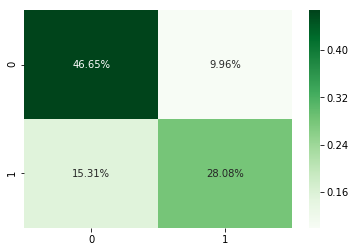

In [39]:
metrics(model, test_padded_sequences, label_test, True)